In [33]:
from keras.layers import Conv1D, GRU, Dense, Dropout, Flatten, MaxPooling1D, Conv2D, MaxPooling2D, LSTM, Bidirectional, Reshape, Permute
from keras.layers.normalization import BatchNormalization
# from keras.models import Model
from keras import models
from keras import layers
from keras.optimizers import Adam
import librosa
from librosa import display
from pydub import AudioSegment as aus
import audiosegment as aud
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import random
import os
from sklearn.utils import shuffle
from keras import regularizers
import audiosegment as aud
from sklearn.metrics import accuracy_score
from keras.models import load_model
import keras
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
import h5py
from keras import models
import tensorflow as tf

In [2]:
extra_data_path_0 = '/home/anton/Documents/extra_data/0/'
extra_data_path_1 = '/home/anton/Documents/extra_data/1/'
data_path_0 = '/home/anton/Documents/command_data/0/'
data_path_1 = '/home/anton/Documents/command_data/1/'
new_data_path_0 = '/home/anton/Documents/new_command_data/0/'
new_data_path_1 = '/home/anton/Documents/new_command_data/1/'

In [3]:
def build_model(data_shape):
    model = models.Sequential()
#     model.add(Input(shape = (data_shape[0], data_shape[1], data_shape[2], )))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(data_shape[0], data_shape[1], data_shape[2], ),  kernel_regularizer=regularizers.l2(0.0005)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((1, 5)))
    model.add(layers.Dropout(0.8))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu',  kernel_regularizer=regularizers.l2(0.0005)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((1, 2)))
    model.add(layers.Dropout(0.8))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu',  kernel_regularizer=regularizers.l2(0.0005)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((1, 2)))
    model.add(layers.Dropout(0.8))
    model.add(Permute((2, 1, 3)))
    model.add(Reshape((data_shape[0], -1)))
    model.add(Bidirectional(
            LSTM(32, activation='tanh', dropout=0.05, recurrent_dropout=0.05, return_sequences=True),
            merge_mode='mul'))
    model.add(Bidirectional(
            LSTM(32, activation='tanh', dropout=0.05, recurrent_dropout=0.05, return_sequences=True),
            merge_mode='mul'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu',  kernel_regularizer=regularizers.l2(0.0005)))
    model.add(layers.Dense(32, activation='relu',  kernel_regularizer=regularizers.l2(0.0005)))
    model.add(layers.Dense(2, activation='sigmoid'))
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
    return model

In [4]:
def model(input_shape):
    
    model = models.Sequential()
    
    model.add(Conv1D(128, kernel_size=16, strides=4, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(5))
    model.add(Dropout(0.8))
    
#     model.add(Conv1D(128, kernel_size=16, strides=4, activation='relu', input_shape=input_shape))
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(3))
#     model.add(Dropout(0.8))
    
#     model.add(Conv1D(128, kernel_size=16, strides=4, activation='relu', input_shape=input_shape))
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(2))
#     model.add(Dropout(0.8))

    model.add(GRU(units = 128, return_sequences = True))
    model.add(Dropout(0.8))
    model.add(BatchNormalization())
    
    model.add(GRU(units = 128, return_sequences = True))
    model.add(Dropout(0.8))
    model.add(BatchNormalization())
    
    model.add(GRU(units = 128, return_sequences = True))
    model.add(Dropout(0.8))
    model.add(BatchNormalization())
    model.add(Dropout(0.8))
    model.add(Flatten())
    
    model.add(layers.Dense(64, activation='relu',  kernel_regularizer=regularizers.l2(0.0005)))
    model.add(layers.Dense(32, activation='relu',  kernel_regularizer=regularizers.l2(0.0005)))
    model.add(Dense(2, activation = "sigmoid"))
    opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
    return model  

In [5]:
def audiosegment_to_ndarray(audiosegment):
    samples = audiosegment.get_array_of_samples()
    samples_float = librosa.util.buf_to_float(samples,n_bytes=2,
                                      dtype=np.float32)
    if audiosegment.channels==2:
        sample_left= np.copy(samples_float[::2])
        sample_right= np.copy(samples_float[1::2])
        sample_all = np.array([sample_left,sample_right])
    else:
        sample_all = samples_float
    spec = librosa.feature.melspectrogram(y=sample_all, sr=audiosegment.frame_rate)
        
    return spec

In [6]:
X_train = []
y_train = []
X_validation = []
y_validation = []

In [3]:
names = []
borders = []
f = open('labels.txt')
lines = f.readlines()
for line in lines:
    line_list = line.split(' ')
    names.append(line_list[0])
    borders.append([line_list[1], line_list[2][:-1]])
border_dict = dict(zip(names, borders))
f.close()

In [4]:
new_names = []
new_borders = []
f = open('new_labels.txt')
lines = f.readlines()
for line in lines:
    line_list = line.split(' ')
    new_names.append(line_list[0])
    new_borders.append([line_list[1], line_list[2][:-1]])
new_border_dict = dict(zip(new_names, new_borders))
f.close()

In [9]:
for i in range(1000):
    sound = aud.from_file(data_path_1 + str(i) + '.wav').resample(sample_rate_Hz=32000, sample_width=2, channels=1)
    
    key_sound = sound[int(border_dict[str(i) + '.wav'][0]) : int(border_dict[str(i) + '.wav'][0]) + 1000]
    key_spect = audiosegment_to_ndarray(key_sound)
    X_train.append(key_spect.reshape(key_spect.shape[0], key_spect.shape[1], 1))
    y_train.append(1)
    
    key_sound = sound[int(border_dict[str(i) + '.wav'][0]) - 100 : int(border_dict[str(i) + '.wav'][0]) + 900]
    key_spect = audiosegment_to_ndarray(key_sound)
    X_train.append(key_spect.reshape(key_spect.shape[0], key_spect.shape[1], 1))
    y_train.append(1)
    
    key_sound = sound[int(border_dict[str(i) + '.wav'][0]) + 100 : int(border_dict[str(i) + '.wav'][0]) + 1100]
    key_spect = audiosegment_to_ndarray(key_sound)
    X_train.append(key_spect.reshape(key_spect.shape[0], key_spect.shape[1], 1))
    y_train.append(1)
    
    down_bord = 0
    up_bord = 0
    while True:
        down_bord = random.randint(0, len(sound) - 2000)
        if (down_bord + 1000 < int(border_dict[str(i) + '.wav'][0])) or (down_bord > int(border_dict[str(i) + '.wav'][0]) + 1000):
            break
    up_bord = down_bord + 1000
    other_sound = sound[down_bord : up_bord]
    other_spect = audiosegment_to_ndarray(other_sound)
    X_train.append(other_spect.reshape(other_spect.shape[0], other_spect.shape[1], 1))
    y_train.append(0)

In [10]:
for i in range(1000):
    sound = aud.from_file(data_path_0 + str(i) + '.wav').resample(sample_rate_Hz=32000, sample_width=2, channels=1)
    
    other_sound = sound[ : 1000]
    other_spect = audiosegment_to_ndarray(other_sound)
    X_train.append(other_spect.reshape(other_spect.shape[0], other_spect.shape[1], 1))
    y_train.append(0)
    
    other_sound = sound[1000 : 2000]
    other_spect = audiosegment_to_ndarray(other_sound)
    X_train.append(other_spect.reshape(other_spect.shape[0], other_spect.shape[1], 1))
    y_train.append(0)

In [11]:
for i in range(2000):
    sound = aud.from_file(new_data_path_1 + str(i) + '.wav').resample(sample_rate_Hz=32000, sample_width=2, channels=1)
    
    key_sound = sound[int(new_border_dict[str(i) + '.wav'][0]) : int(new_border_dict[str(i) + '.wav'][0]) + 1000]
    key_spect = audiosegment_to_ndarray(key_sound)
    X_train.append(key_spect.reshape(key_spect.shape[0], key_spect.shape[1], 1))
    y_train.append(1)
    
    if int(new_border_dict[str(i) + '.wav'][0]) - 100 >= 0:
        key_sound = sound[int(new_border_dict[str(i) + '.wav'][0]) - 100 : int(new_border_dict[str(i) + '.wav'][0]) + 900]
        key_spect = audiosegment_to_ndarray(key_sound)
        X_train.append(key_spect.reshape(key_spect.shape[0], key_spect.shape[1], 1))
        y_train.append(1)
        
    if int(new_border_dict[str(i) + '.wav'][0]) + 1100 <= len(sound):
        key_sound = sound[int(new_border_dict[str(i) + '.wav'][0]) + 100 : int(new_border_dict[str(i) + '.wav'][0]) + 1100]
        key_spect = audiosegment_to_ndarray(key_sound)
        X_train.append(key_spect.reshape(key_spect.shape[0], key_spect.shape[1], 1))
        y_train.append(1)
    
    down_bord = 0
    up_bord = 0
    while True:
        down_bord = random.randint(0, len(sound) - 1100)
        if (down_bord + 1000 < int(new_border_dict[str(i) + '.wav'][0])) or (down_bord > int(new_border_dict[str(i) + '.wav'][0]) + 1000):
            break
    up_bord = down_bord + 1000
    other_sound = sound[down_bord : up_bord]
    other_spect = audiosegment_to_ndarray(other_sound)
    X_train.append(other_spect.reshape(other_spect.shape[0], other_spect.shape[1], 1))
    y_train.append(0)

In [12]:
for i in range(2000):
    sound = aud.from_file(new_data_path_0 + str(i) + '.wav').resample(sample_rate_Hz=32000, sample_width=2, channels=1)
    
    other_sound = sound[ : 1000]
    other_spect = audiosegment_to_ndarray(other_sound)
    X_train.append(other_spect.reshape(other_spect.shape[0], other_spect.shape[1], 1))
    y_train.append(0)
    
    other_sound = sound[1000 : 2000]
    other_spect = audiosegment_to_ndarray(other_sound)
    X_train.append(other_spect.reshape(other_spect.shape[0], other_spect.shape[1], 1))
    y_train.append(0)

In [13]:
for i, s in enumerate(os.listdir(extra_data_path_0)):
    sound = aud.from_file(extra_data_path_0 + s).resample(sample_rate_Hz=32000, sample_width=2, channels=1)
    
    if len(sound) >= 1000:
        key_sound = sound[:1000]
        key_spect = audiosegment_to_ndarray(key_sound)
        X_train.append(key_spect.reshape(key_spect.shape[0], key_spect.shape[1], 1))
        y_train.append(0) 

In [14]:
for i, s in enumerate(os.listdir(extra_data_path_1)):
    sound = aud.from_file(extra_data_path_1 + s).resample(sample_rate_Hz=32000, sample_width=2, channels=1)
    
    if len(sound) >= 1000:
        key_sound = sound[:1000]
        key_spect = audiosegment_to_ndarray(key_sound)
        X_train.append(key_spect.reshape(key_spect.shape[0], key_spect.shape[1], 1))
        y_train.append(1) 

In [15]:
for i in range(1000, 1500):
    sound = aud.from_file(data_path_1 + str(i) + '.wav').resample(sample_rate_Hz=32000, sample_width=2, channels=1)
    
    key_sound = sound[int(border_dict[str(i) + '.wav'][0]) : int(border_dict[str(i) + '.wav'][0]) + 1000]
    key_spect = audiosegment_to_ndarray(key_sound)
    X_validation.append(key_spect.reshape(key_spect.shape[0], key_spect.shape[1], 1))
    y_validation.append(1)
    
    key_sound = sound[int(border_dict[str(i) + '.wav'][0]) - 100 : int(border_dict[str(i) + '.wav'][0]) + 900]
    key_spect = audiosegment_to_ndarray(key_sound)
    X_validation.append(key_spect.reshape(key_spect.shape[0], key_spect.shape[1], 1))
    y_validation.append(1)
    
    key_sound = sound[int(border_dict[str(i) + '.wav'][0]) + 100 : int(border_dict[str(i) + '.wav'][0]) + 1100]
    key_spect = audiosegment_to_ndarray(key_sound)
    X_validation.append(key_spect.reshape(key_spect.shape[0], key_spect.shape[1], 1))
    y_validation.append(1)
    
    down_bord = 0
    up_bord = 0
    while True:
        down_bord = random.randint(0, len(sound) - 2000)
        if (down_bord + 1000 < int(border_dict[str(i) + '.wav'][0])) or (down_bord > int(border_dict[str(i) + '.wav'][0]) + 1000):
            break
    up_bord = down_bord + 1000
    other_sound = sound[down_bord : up_bord]
    other_spect = audiosegment_to_ndarray(other_sound)
    X_validation.append(other_spect.reshape(other_spect.shape[0], other_spect.shape[1], 1))
    y_validation.append(0)

In [16]:
for i in range(1000, 1500):
    sound = aud.from_file(data_path_0 + str(i) + '.wav').resample(sample_rate_Hz=32000, sample_width=2, channels=1)
    
    other_sound = sound[:1000]
    other_spect = audiosegment_to_ndarray(other_sound)
    X_validation.append(other_spect.reshape(other_spect.shape[0], other_spect.shape[1], 1))
    y_validation.append(0)
    
    other_sound = sound[1000:2000]
    other_spect = audiosegment_to_ndarray(other_sound)
    X_validation.append(other_spect.reshape(other_spect.shape[0], other_spect.shape[1], 1))
    y_validation.append(0)

In [17]:
for i in range(2000, 2500):
    sound = aud.from_file(new_data_path_1 + str(i) + '.wav').resample(sample_rate_Hz=32000, sample_width=2, channels=1)
    
    key_sound = sound[int(new_border_dict[str(i) + '.wav'][0]) : int(new_border_dict[str(i) + '.wav'][0]) + 1000]
    key_spect = audiosegment_to_ndarray(key_sound)
    X_validation.append(key_spect)
    y_validation.append(1)
    
    if int(new_border_dict[str(i) + '.wav'][0]) - 100 >= 0:
        key_sound = sound[int(new_border_dict[str(i) + '.wav'][0]) - 100 : int(new_border_dict[str(i) + '.wav'][0]) + 900]
        key_spect = audiosegment_to_ndarray(key_sound)
        X_validation.append(key_spect.reshape(key_spect.shape[0], key_spect.shape[1], 1))
        y_validation.append(1)
        
    if int(new_border_dict[str(i) + '.wav'][0]) + 1100 <= len(sound):
        key_sound = sound[int(new_border_dict[str(i) + '.wav'][0]) + 100 : int(new_border_dict[str(i) + '.wav'][0]) + 1100]
        key_spect = audiosegment_to_ndarray(key_sound)
        X_validation.append(key_spect.reshape(key_spect.shape[0], key_spect.shape[1], 1))
        y_validation.append(1)
    
    down_bord = 0
    up_bord = 0
    while True:
        down_bord = random.randint(0, len(sound) - 1100)
        if (down_bord + 1000 < int(new_border_dict[str(i) + '.wav'][0])) or (down_bord > int(new_border_dict[str(i) + '.wav'][0]) + 1000):
            break
    up_bord = down_bord + 1000
    other_sound = sound[down_bord : up_bord]
    other_spect = audiosegment_to_ndarray(other_sound)
    X_validation.append(other_spect.reshape(other_spect.shape[0], other_spect.shape[1], 1))
    y_validation.append(0)

In [18]:
for i in range(2000, 2500):
    sound = aud.from_file(new_data_path_0 + str(i) + '.wav').resample(sample_rate_Hz=32000, sample_width=2, channels=1)
    
    other_sound = sound[ : 1000]
    other_spect = audiosegment_to_ndarray(other_sound)
    X_validation.append(other_spect.reshape(other_spect.shape[0], other_spect.shape[1], 1))
    y_validation.append(0)
    
    other_sound = sound[1000 : 2000]
    other_spect = audiosegment_to_ndarray(other_sound)
    X_validation.append(other_spect.reshape(other_spect.shape[0], other_spect.shape[1], 1))
    y_validation.append(0)

In [19]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_validation, y_validation = shuffle(X_validation, y_validation, random_state=0)
y_train = [[0, 1] if i == 1 else [1, 0] for i in y_train]
y_validation = [[0, 1] if i == 1 else [1, 0] for i in y_validation]

In [24]:
model = build_model(X_train[0].shape)

In [21]:
np.array(X_train).shape

(23410, 128, 63, 1)

In [22]:
for i, x in enumerate(X_validation):
    X_validation[i] = x.reshape(x.shape[0], x.shape[1], 1)

In [25]:
history = model.fit(np.array(X_train), np.array(y_train), epochs=8, batch_size=64, validation_data=(np.array(X_validation), np.array(y_validation)))

Train on 23410 samples, validate on 5964 samples
Epoch 1/8
23410/23410 [==============================] - 2254s 96ms/step - loss: 0.5559 - acc: 0.7411 - val_loss: 0.6260 - val_acc: 0.7500
Epoch 2/8
23410/23410 [==============================] - 4004s 171ms/step - loss: 0.4689 - acc: 0.8479 - val_loss: 0.7676 - val_acc: 0.5395
Epoch 3/8
23410/23410 [==============================] - 2075s 89ms/step - loss: 0.4465 - acc: 0.8771 - val_loss: 0.4416 - val_acc: 0.8784
Epoch 4/8
23410/23410 [==============================] - 2180s 93ms/step - loss: 0.4300 - acc: 0.8895 - val_loss: 0.4292 - val_acc: 0.8892
Epoch 5/8
23410/23410 [==============================] - 2167s 93ms/step - loss: 0.4069 - acc: 0.9010 - val_loss: 0.4208 - val_acc: 0.8918
Epoch 6/8
23410/23410 [==============================] - 2168s 93ms/step - loss: 0.3944 - acc: 0.9054 - val_loss: 0.4276 - val_acc: 0.8893
Epoch 7/8
23410/23410 [==============================] - 2182s 93ms/step - loss: 0.3833 - acc: 0.9088 - val_loss: 0.

In [26]:
model.save('final_model.h5')

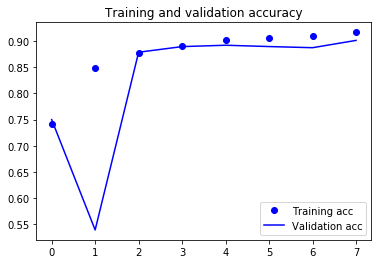

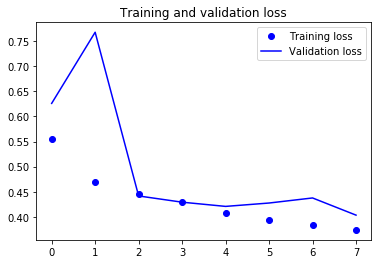

In [27]:
plt.plot(history.history['acc'], 'bo', label='Training acc')
plt.plot(history.history['val_acc'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(history.history['loss'], 'bo', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [5]:
test_0 = '/home/anton/Documents/test/0/'
test_1 = '/home/anton/Documents/test/1/'
new_test_0 = '/home/anton/Documents/new_test/0/'
new_test_1 = '/home/anton/Documents/new_test/1/'

In [8]:
test_sounds = []
test_labels = []
label_file = []
test_names = []

In [9]:
for s in os.listdir(test_0):
    test_sounds.append(aud.from_file(test_0 + s).resample(sample_rate_Hz=16000, sample_width=2, channels=1))
    test_labels.append(0)
    label_file.append('o')
    test_names.append(s)

In [10]:
for s in os.listdir(test_1):
    test_sounds.append(aud.from_file(test_1 + s).resample(sample_rate_Hz=16000, sample_width=2, channels=1))
    test_labels.append(1)
    label_file.append('o')
    test_names.append(s)

In [11]:
for s in os.listdir(new_test_0):
    test_sounds.append(aud.from_file(new_test_0 + s).resample(sample_rate_Hz=16000, sample_width=2, channels=1))
    test_labels.append(0)
    label_file.append('n')
    test_names.append(s)

In [12]:
for s in os.listdir(new_test_1):
    test_sounds.append(aud.from_file(new_test_1 + s).resample(sample_rate_Hz=16000, sample_width=2, channels=1))
    test_labels.append(1)
    label_file.append('n')
    test_names.append(s)

In [13]:
test_sounds, test_labels, label_file, test_names = shuffle(test_sounds, test_labels, label_file, test_names, random_state=0)

In [34]:
model = tf.keras.models.load_wei('av_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [24]:
model = h5py.File('av_model.h5', 'r')
# print(f.attrs.get('keras_version'))

In [28]:
sample_rate = 16000

In [26]:
def audiosegment_to_ndarray(audiosegment):
    samples = audiosegment.get_array_of_samples()
    audio_signal = librosa.util.buf_to_float(samples,n_bytes=2,
                                      dtype=np.float32)
    
    audio_signal = audio_signal/np.amax(audio_signal)
    zcr_signal = librosa.feature.zero_crossing_rate(audio_signal, frame_length=512, hop_length=410) #(1,32)
    mfcc_signal = librosa.feature.mfcc(audio_signal,sample_rate, n_fft=1024, hop_length=410) # (20,32)
    centr_signal = librosa.feature.spectral_centroid(audio_signal, sample_rate, n_fft=1024, hop_length=410)# (1,32)
    rolloff_signal = librosa.feature.spectral_rolloff(audio_signal,n_fft=1024, hop_length=410) # (1,32)
    # get features matrix by concatenating all features
    features_mat = np.concatenate((zcr_signal, mfcc_signal, centr_signal, rolloff_signal), axis=0)
    return features_mat

3613.wav
0
31


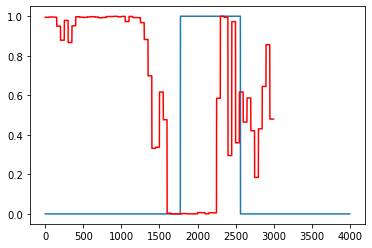

1992.wav
1
95


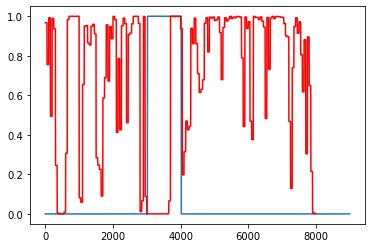

2035.wav
2
90


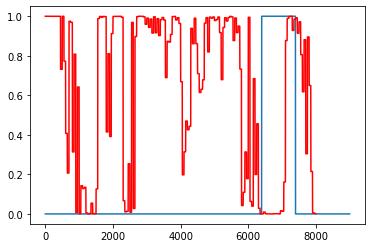

1973.wav
3
41


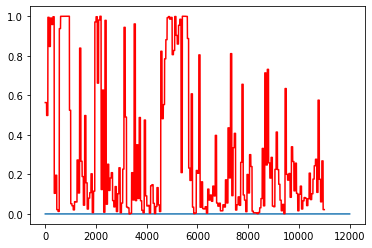

2922.wav
4
38


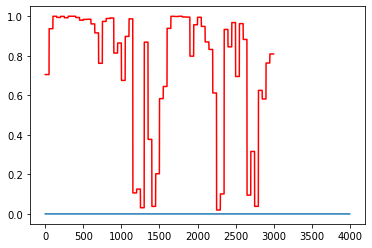

2007.wav
5
181


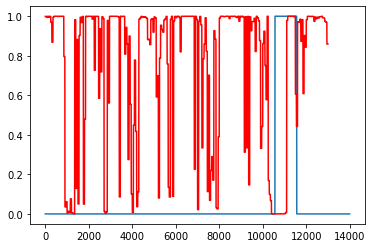

2939.wav
6
45


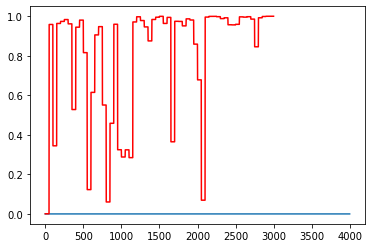

2950.wav
7
54


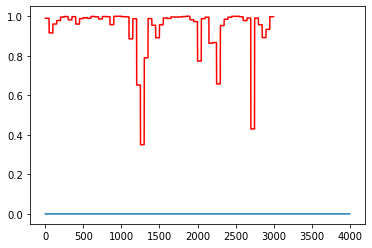

3665.wav


KeyboardInterrupt: 

In [38]:
pr = []
for i, s in enumerate(test_sounds):
    print(test_names[i])
    real_values = []
    predicted_values = []
    p = 0
    if test_labels[i] == 0:
        real_values = [0 for k in range(len(s))]
        for j in range(0, len(s) - 1000, 50):
            aaa = audiosegment_to_ndarray(s[j:j+1000])
            aa = []
            aa.append(aaa)
            aa = np.array(aa)
            pr_val = model.predict(aa)[0][0]
            if pr_val > 0.8:
                p += 1
            for _ in range(50):
                predicted_values.append(pr_val)
    else:
        start = 0
        end = 0
        if label_file[i] == 'o':
            start = border_dict[test_names[i]][0]
            end = border_dict[test_names[i]][1]
        else:
            start = new_border_dict[test_names[i]][0]
            end = new_border_dict[test_names[i]][1]
        real_values = [0 for k in range(len(s))]
        for k in range(int(start), int(end)):
            real_values[k] = 1
        for j in range(0, len(s) - 1000, 50):
            aaa = audiosegment_to_ndarray(s[j:j+1000])
            aa = []
            aa.append(aaa)
            aa = np.array(aa)
            pr_val = model.predict(aa)[0][0]
            if pr_val > 0.8:
                p += 1
            for _ in range(50):
                predicted_values.append(pr_val)
    if p > 0:
        pr.append(1)
    else:
        pr.append(0)
    print(i)
    print(p)
    plt.plot(real_values)
    plt.plot(predicted_values, color='red')
    plt.show()

In [41]:
accuracy_score(test_labels, pr)

0.8405228758169935

In [42]:
fn = 0
tp = 0
fp = 0
tn = 0
for i, label in enumerate(test_labels):
    if label == 1 and pr[i] == 1:
        tp += 1
    if label == 1 and pr[i] == 0:
        fn += 1
    if label == 0 and pr[i] == 1:
        fp += 1
    if label == 0 and pr[i] == 0:
        tn += 1

In [43]:
print(tp, fn, fp, tn)

385 86 36 258


In [45]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)

In [46]:
f1_score = 2*recall*precision / (recall + precision)
f1_score

0.8632286995515696